## Baixar Bibliotecas

In [46]:
import tensorflow as tf
from tensorflow import keras 
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, BatchNormalization, Dropout, Flatten, Conv2D, MaxPooling2D
from tensorflow.keras.optimizers import Adam
import numpy as np
import random
import matplotlib.pyplot as plt
%matplotlib inline

## Diretório para o Dataset

In [47]:
test_dir = r'D:\IC - Prof Rubelmar\Dataset Soldagem\Audio Soldagem Edição 2\Testes\Espectograma Tudo Junto\Amostra'
train_dir = r'D:\IC - Prof Rubelmar\Dataset Soldagem\Audio Soldagem Edição 2\Treinamento\Espectograma Tudo Junto'

## Algumas definições Importantes

In [48]:
im_shape = (100,100)
seed = 10
BATCH_SIZE = 2

## Preprocessamento das Imagens

In [49]:
# Subdivisão em trai e validação
data_generator = ImageDataGenerator(rescale=1./255, validation_split=0.2)
val_data_generator = ImageDataGenerator(rescale=1./255, validation_split=0.2)

## Data Generator

In [50]:
data_generator = ImageDataGenerator(
       validation_split=0.2,
       rescale=1./255,
       horizontal_flip=True,
       fill_mode='nearest')

val_data_generator = ImageDataGenerator(rescale=1./255, validation_split=0.2)






In [51]:
# Generator para parte train
train_generator = data_generator.flow_from_directory(train_dir, target_size=im_shape, shuffle=True, seed=seed,
                                                     class_mode='categorical', batch_size=BATCH_SIZE, subset="training")
# Generator para parte validação
validation_generator = val_data_generator.flow_from_directory(train_dir, target_size=im_shape, shuffle=False, seed=seed,
                                                     class_mode='categorical', batch_size=BATCH_SIZE, subset="validation")

# Generator para dataset de teste
test_generator = ImageDataGenerator(rescale=1./255)
test_generator = test_generator.flow_from_directory(test_dir, target_size=im_shape, shuffle=False, seed=seed,
                                                     class_mode='categorical', batch_size=BATCH_SIZE)

nb_train_samples = train_generator.samples
nb_validation_samples = validation_generator.samples
nb_test_samples = test_generator.samples
classes = list(train_generator.class_indices.keys())
print('Classes: '+str(classes))
num_classes  = len(classes)



Found 343 images belonging to 2 classes.
Found 85 images belonging to 2 classes.
Found 8 images belonging to 2 classes.
Classes: ['Furou', 'Não Furou']


## Vizualição de Algumas Imagens

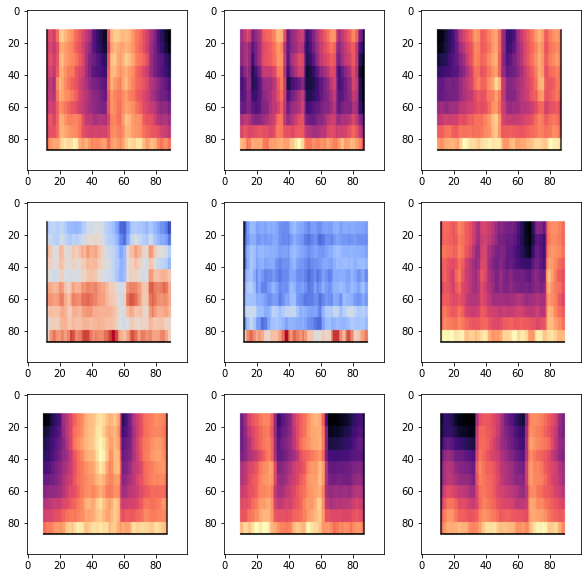

In [52]:
# Visualizing some examples
plt.figure(figsize=(10,10))
for i in range(9):
    #gera subfigures
    plt.subplot(330 + 1 + i)
    batch = train_generator.next()[0]*255
    image = batch[0].astype('uint8')
    plt.imshow(image)
plt.show()

## Simples Modelo de CNN

In [53]:
def get_model():
    model = Sequential()
    model.add(Conv2D(20, kernel_size=(3, 3),
                    activation='relu',
                    input_shape=(im_shape[0],im_shape[1],3)))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Conv2D(40, kernel_size=(3,3), activation='relu'))
    model.add(Flatten())
    model.add(Dense(100, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(num_classes, activation='softmax'))
    model.summary()
    model.compile(loss='categorical_crossentropy',
              optimizer=Adam(),
              metrics=['accuracy'])
    return model 

model = get_model()
#salva o modelo 

model.save("my_model")


Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 98, 98, 20)        560       
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 49, 49, 20)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 47, 47, 40)        7240      
_________________________________________________________________
flatten_2 (Flatten)          (None, 88360)             0         
_________________________________________________________________
dense_4 (Dense)              (None, 100)               8836100   
_________________________________________________________________
dropout_2 (Dropout)          (None, 100)               0         
_________________________________________________________________
dense_5 (Dense)              (None, 2)                

In [54]:
epochs = 80

#Callback to save the best model
callbacks_list = [
    keras.callbacks.ModelCheckpoint(
        filepath='model.h5',
        monitor='val_loss', save_best_only=True, verbose=1),
    keras.callbacks.EarlyStopping(monitor='val_loss', patience=15,verbose=1)
]

#Training
history = model.fit(
        train_generator,
        steps_per_epoch=nb_train_samples // BATCH_SIZE,
        epochs=epochs,
        callbacks = callbacks_list,
        validation_data=validation_generator,
        verbose = 1,
        validation_steps=nb_validation_samples // BATCH_SIZE)

Epoch 1/80
171/171 [==============================] - 14s 78ms/step - loss: 0.6472 - accuracy: 0.8152 - val_loss: 1.1109 - val_accuracy: 0.5595

Epoch 00001: val_loss improved from inf to 1.11090, saving model to model.h5
Epoch 2/80
171/171 [==============================] - 13s 78ms/step - loss: 0.3732 - accuracy: 0.8651 - val_loss: 0.5436 - val_accuracy: 0.6667

Epoch 00002: val_loss improved from 1.11090 to 0.54357, saving model to model.h5
Epoch 3/80
171/171 [==============================] - 13s 77ms/step - loss: 0.4086 - accuracy: 0.8475 - val_loss: 2.5765 - val_accuracy: 0.5833

Epoch 00003: val_loss did not improve from 0.54357
Epoch 4/80
171/171 [==============================] - 13s 78ms/step - loss: 0.3200 - accuracy: 0.8798 - val_loss: 1.0937 - val_accuracy: 0.5833

Epoch 00004: val_loss did not improve from 0.54357
Epoch 5/80
171/171 [==============================] - 13s 78ms/step - loss: 0.3077 - accuracy: 0.8798 - val_loss: 1.0647 - val_accuracy: 0.5714

Epoch 00005: va

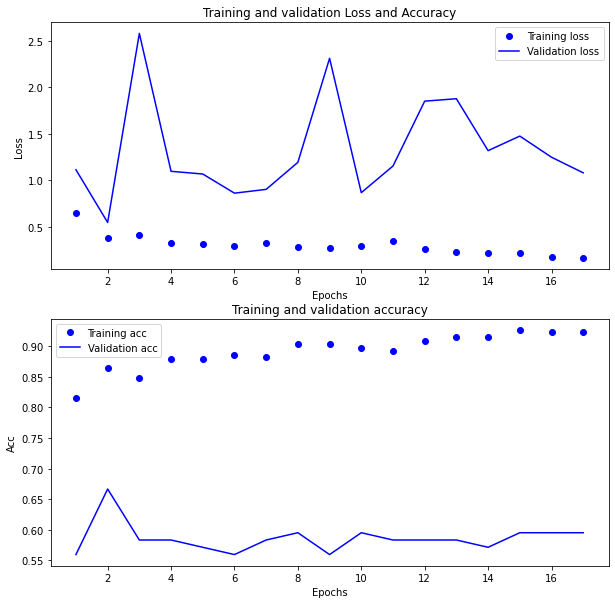

In [55]:
import matplotlib.pyplot as plt

history_dict = history.history
loss_values = history_dict['loss']
val_loss_values = history_dict['val_loss']

epochs_x = range(1, len(loss_values) + 1)
plt.figure(figsize=(10,10))
plt.subplot(2,1,1)
plt.plot(epochs_x, loss_values, 'bo', label='Training loss')
plt.plot(epochs_x, val_loss_values, 'b', label='Validation loss')
plt.title('Training and validation Loss and Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.subplot(2,1,2)
acc_values = history_dict['accuracy']
val_acc_values = history_dict['val_accuracy']
plt.plot(epochs_x, acc_values, 'bo', label='Training acc')
plt.plot(epochs_x, val_acc_values, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Acc')
plt.legend()
plt.show()

In [56]:
# Using the validation dataset
score = model.evaluate_generator(validation_generator)
print('Val loss:', score[0])
print('Val accuracy:', score[1])

C:\Users\Marcus_Eduardo\anaconda3\envs\scienv\lib\site-packages\tensorflow\python\keras\engine\training.py:1973: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  warnings.warn('`Model.evaluate_generator` is deprecated and '


Val loss: 1.086353063583374
Val accuracy: 0.5882353186607361


In [57]:
# Using the test dataset
score = model.evaluate_generator(test_generator)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 0.14773131906986237
Test accuracy: 1.0


In [58]:
import itertools

#Plot the confusion matrix. Set Normalize = True/False
def plot_confusion_matrix(cm, classes, normalize=True, title='Confusion matrix', cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.figure(figsize=(10,10))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        cm = np.around(cm, decimals=2)
        cm[np.isnan(cm)] = 0.0
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

C:\Users\Marcus_Eduardo\anaconda3\envs\scienv\lib\site-packages\tensorflow\python\keras\engine\training.py:2001: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


Classification Report
              precision    recall  f1-score   support

       Furou       1.00      1.00      1.00         4
   Não Furou       1.00      1.00      1.00         4

    accuracy                           1.00         8
   macro avg       1.00      1.00      1.00         8
weighted avg       1.00      1.00      1.00         8



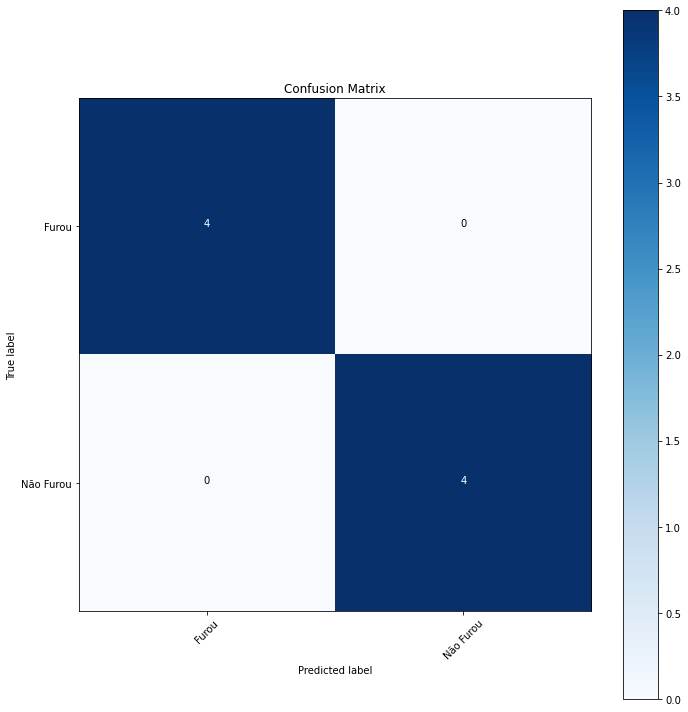

In [59]:
# Some reports
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np

#On test dataset
Y_pred = model.predict_generator(test_generator)
y_pred = np.argmax(Y_pred, axis=1)
target_names = classes

#Confution Matrix
cm = confusion_matrix(test_generator.classes, y_pred)
plot_confusion_matrix(cm, target_names, normalize=False, title='Confusion Matrix')

#Classification Report
print('Classification Report')
print(classification_report(test_generator.classes, y_pred, target_names=target_names))